In [1]:
import numpy as np

## Load Evaluation Results

In [2]:
import sys
from json import load
from pprint import pprint as pp
import matplotlib.pyplot as plt
import numpy as np

sys.path.append('../')

from utils import ConfigHandler, Similarity, last_path
from mapper import Mapper
from evaluation import EvaluationHandler

config = ConfigHandler()


approaches = ['standard','prepruning','pospruning']
# approaches = ['standard']
databases = ['imdb','mondial']
querysets_hash = {
    'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
    'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
}

repeat = 10

parallel_cn = False

subfolder = ''


def load_evaluations(databases,approaches,subfolder=''):
    evaluation = {}
    for database in databases:
        observations = {}
        for j,queryset in enumerate(querysets_hash[database]):
            for i,approach in enumerate(approaches):
                queryset_config_file = f'../../config/queryset_configs/{queryset}_config.json'
                config = ConfigHandler(reset = True,queryset_config_file=queryset_config_file)
                
                config.results_directory += subfolder
                results_filename = last_path(f'{config.results_directory}{config.queryset_name}-{approach}-%03d.json')
#                 print(results_filename)

                evaluation.setdefault(database,{}).setdefault(queryset,{}).setdefault(approach,{})
                
                try:
                    with open(results_filename,mode='r') as f:
                        evaluation[database][queryset][approach] = load(f)['evaluation']
                except FileNotFoundError:
                    print(f'File {results_filename} not found.')
                    continue
    return evaluation

evaluation = load_evaluations(databases,approaches,subfolder=subfolder)

## Num. Keyword Matches

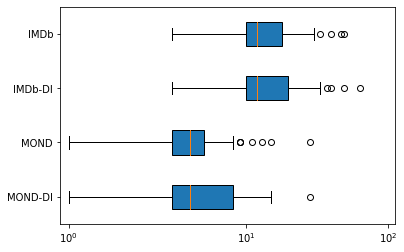

In [3]:
def plot_num_keyword_matches(evaluation):    
    databases = ['imdb','mondial']

    querysets_hash = {
        'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
        'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
    } 

    labels_hash = {
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
    }
    
    data = []
    labels = []
    
    margin = 0.05
    xlim = [10**(0-margin), 10**(2+margin)]
    
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    
    for database in databases:
        for queryset in querysets_hash[database]:
            cur_data = evaluation[database][queryset]['standard']['num_keyword_matches']
            data.append(cur_data)
            labels.append(labels_hash[queryset])
          
    plt.boxplot(data,labels=labels,vert=0,patch_artist=True)
    plt.xscale('symlog')    
    plt.xlim(xlim)
    
    plt.savefig(f'{config.plots_directory}num-keyword-matches.pdf')  
    plt.show()

plot_num_keyword_matches(evaluation)

## Num. Query Matches

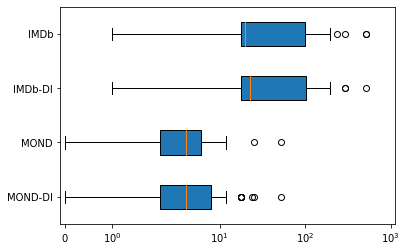

In [4]:
def plot_num_query_matches(evaluation):    
    databases = ['imdb','mondial']

    querysets_hash = {
        'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
        'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
    } 

    labels_hash = {
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
    }
    
    data = []
    labels = []
    
    margin = 0.05
    xlim = [-2*margin, 10**(3+margin)]
    
    fig, ax = plt.subplots()
    ax.invert_yaxis()
    
    for database in databases:
        for queryset in querysets_hash[database]:
            cur_data = evaluation[database][queryset]['standard']['num_query_matches']
            data.append(cur_data)
            labels.append(labels_hash[queryset])
          
    plt.boxplot(data,labels=labels,vert=0,patch_artist=True)
    plt.xscale('symlog')
        
    plt.xlim(xlim)
    plt.savefig(f'{config.plots_directory}num-query-matches.pdf')  
    plt.show()

plot_num_query_matches(evaluation)

## Query Match Ranking

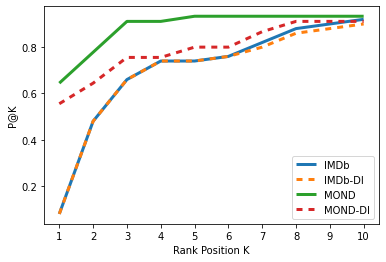

In [5]:
def query_matches_precision_plot(evaluation):
    metrics = [f'p@{k+1}' for k in range(10)]
    labels_hash = {
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
    }
    dashes_order = [(1,0),(2,2),(1,0),(2,2)]

    precision_data = [
        (
            labels_hash[queryset],
            [
                evaluation[database][queryset]['standard']['query_matches'][metric]
                for metric in metrics
            ]
        )
        for database in evaluation
        for queryset in evaluation[database]
    ]

    x_data = range(1,10+1)
    for (label,y_data),dashes in zip(precision_data,dashes_order):
        plt.plot(
            x_data,
            y_data,
            linewidth = 3,
            label = label,
            dashes = dashes
        )

    plt.xticks(np.arange(1, 10+1, 1.0))
    plt.xlabel('Rank Position K')
    plt.ylabel('P@K')
    plt.legend()
    plt.savefig(f'{config.plots_directory}qms-precision-at-k.pdf')  
    plt.show()

query_matches_precision_plot(evaluation)

## Candidate Network Ranking

In [6]:
import sys
from json import load

sys.path.append('../')

from utils import ConfigHandler, last_path
from mapper import Mapper
from evaluation import EvaluationHandler


import matplotlib
import matplotlib.pyplot as plt
import numpy as np

config = ConfigHandler()


### Grouped Barplot

In [7]:
def grouped_bar_plot(observations,n,color_labels,group_labels,observation_labels,**kwargs):
    m = len(color_labels)
    num_groups = len(group_labels)
    group_size = n//num_groups if num_groups > 0 else 0    
    
    hide_group_label = kwargs.get('hide_group_label',False)
    title = kwargs.get('title','')
    ylabel = kwargs.get('ylabel','')
    filename = kwargs.get('filename',None)
    observation_margin = kwargs.get('observation_margin',0.05) 
    subgroup_margin = kwargs.get('subgroup_margin',0.25)
    group_margin = kwargs.get('group_margin',0.8)
    bbox_to_anchor=kwargs.get('bbox_to_anchor', (1.1, 1.00))
    
    group_labels = ['\n\n'+label for label in group_labels]

    data = observations

    width  = 1/(m)

    last_observation = 0
    last_group = 0
    step = 0

    x = []
    group_x = []
    for i in range(n):
        last_observation+=step
        x.append(last_observation)    
        
        end_of_group = (i+1)%(group_size) == 0
        if end_of_group:
            step=1+group_margin

            middle_of_group = (last_observation+last_group)/2
            
            if not hide_group_label:
                group_x.append(middle_of_group)           
            last_group=last_observation+step
        else:
            step=1+subgroup_margin

    x=np.array(x)
    group_x = np.array(group_x)   

    fig, ax = plt.subplots(figsize = [15, 4.8])
    for i in range(m):
        ax.bar(x+( (1-m)/2 + i)*width, data[i], width*(1-2*observation_margin), label=color_labels[i])

    ax.set_xticks(x)
    ax.set_xticklabels(observation_labels)

    if not hide_group_label:
        ax.set_xticks(np.concatenate((x,group_x)))
        ax.set_xticklabels(observation_labels+group_labels)

    ax.set_ylim(ymin=0, ymax=1)

    lgd=ax.legend(bbox_to_anchor=bbox_to_anchor)

    if filename is not None:
        plt.savefig(filename, bbox_extra_artists=(lgd,), bbox_inches='tight')
        
    return plt

### Standard CN Ranking

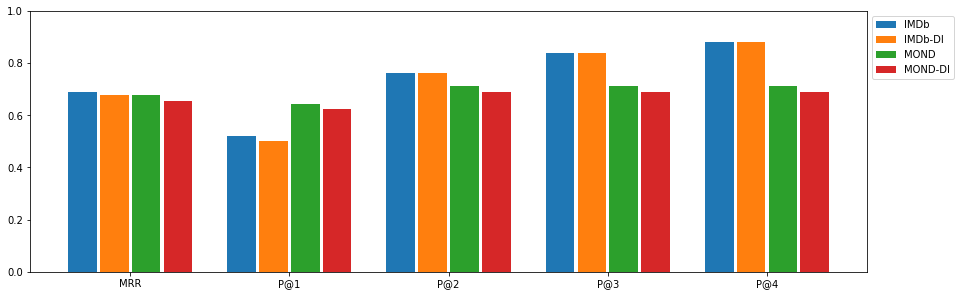

In [14]:
def cn_standard_ranking(evaluation,**kwargs):
    metrics = ['mrr']+[f'p@{k+1}' for k in range(4)]
    group_labels = ['group']

    databases = ['imdb','mondial']

    querysets_hash = {
        'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
        'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
    } 

    labels = {
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
    }

    observations = [
                [
                    evaluation[database][queryset]['standard']['candidate_networks'][metric]
                    for metric in metrics
                ]
                for database in databases
                for queryset in querysets_hash[database]   
            ]

    
    
    observation_labels = [metric.upper() for metric in metrics]

    color_labels = [labels[queryset] 
                    for database in databases 
                    for queryset in querysets_hash[database]]

    filename = kwargs.get('filename',f'{config.plots_directory}cn_ranking.pdf')
    grouped_bar_plot(
        observations,
        len(observation_labels),
        color_labels,
        group_labels,
        observation_labels,
        filename=filename,
        hide_group_label=True,
        bbox_to_anchor=(1.11,1)
    )
    
#     print(observations)
    
cn_standard_ranking(evaluation)

### Instance Pruning CN Ranking

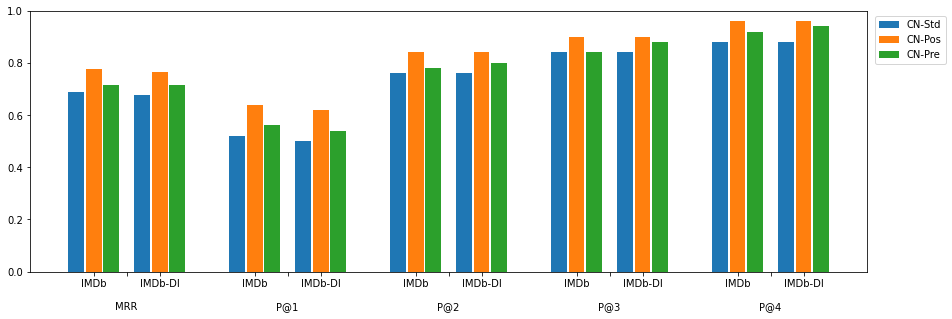

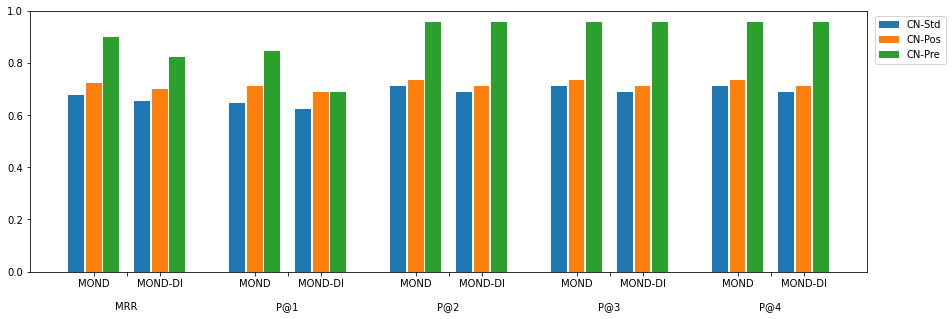

In [9]:
def instance_pruning_plot(evaluation):
    metrics = ['mrr']+[f'p@{k+1}' for k in range(4)]
    group_labels = [name.upper() for name in metrics]

    approaches = {
        'standard':'CN-Std',
        'pospruning':'CN-Pos',
        'prepruning':'CN-Pre',
    }

    databases = ['imdb','mondial']

    querysets_hash = {
        'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
        'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
    } 

    labels = {
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
    }
    
    data = [
        (
            database,
            [
                (
                    approach,
                    [
                        evaluation[database][queryset][approach]['candidate_networks'][metric]
                        for metric in metrics
                        for queryset in querysets_hash[database]   
                    ],
                )
                for approach in approaches
            ]
        )
        for database in databases
    ]
    
    for database,approach_results in data:
        observations = [results for approach,results in approach_results]       

        observation_labels = [
            labels[queryset]
            for group in group_labels
            for queryset in querysets_hash[database]
        ]
        
        filename = f'{config.plots_directory}instance-based-pruning-evaluation-{database}.pdf'
        grouped_bar_plot(
            observations,
            len(observation_labels),
            list(approaches.values()),
            group_labels,
            observation_labels,
            filename=filename,
        )
    plt.show()
        
#         print(observations)
instance_pruning_plot(evaluation)

### QUEST Comparison CN Ranking

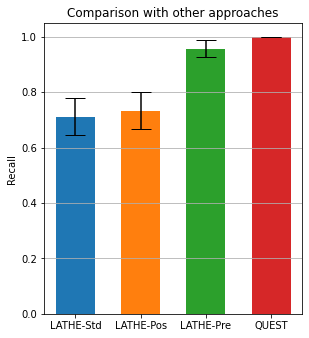

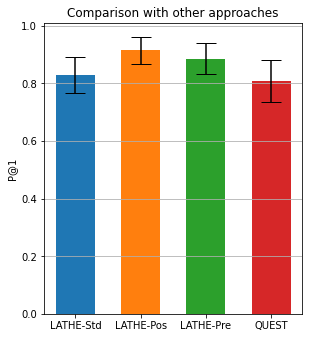

In [10]:
def plot_quest_comparison(evaluation,other_approaches = False):
    approaches = {
        'standard':'LATHE-Std',
        'pospruning':'LATHE-Pos',
        'prepruning':'LATHE-Pre',
    }

    precision_hard_coded = {
        'QUEST': (0.808, 0.073),
        'BANKS': (0.244, 0.044),
        'DISCOVER': (0.601, 0.043),
        'DISCOVER-II': (0.443, 0.046),
        'BANKS-II': (0.666, 0.042),
        'DPBF': (0.769, 0.037),
        'BLINKS': (0.83, 0.033),
        'STAR': (0.688, 0.042)
    }


    recall_hard_coded = {
        'QUEST':(1,0),
        'BANKS':(0.332,0.043),
        'DISCOVER':(0.774,0.033),
        'DISCOVER-II':(0.788,0.033),
        'BANKS-II':(0.769,0.035),
        'DPBF':(0.955,0.016),
        'BLINKS':(0.968,0.011),
        'STAR':(0.616,0.044),
        }


    data = {
        'Recall':{},
        'P@1':{},
    }
    
    queries_condition = lambda num_query: num_query<30 or num_query>39

    for x,(approach,label) in enumerate(approaches.items()):
        precision_at_1 = np.array(
            [       
                1 
                if position==1 else 0 
                for num_query,position in enumerate(evaluation['mondial']['coffman_mondial'][approach]['candidate_networks']['relevant_positions'])
                if queries_condition(num_query)
            ]
        )

        recall = np.array(
            [       
                1 
                if position!=-1 else 0 
                for num_query,position in enumerate(evaluation['mondial']['coffman_mondial'][approach]['candidate_networks']['relevant_positions'])
                if queries_condition
            ]
        )

        precision_std_err = precision_at_1.std()/(len(precision_at_1)**0.5)    
        data['P@1'][label] = ( 
            precision_at_1.mean(),
            precision_std_err
        )

        recall_std_err = recall.std()/(len(recall)**0.5)
        data['Recall'][label] = (
            recall.mean(),
            recall_std_err
        )
    if other_approaches == False:
        data['P@1']['QUEST']    = precision_hard_coded['QUEST']
        data['Recall']['QUEST'] = recall_hard_coded['QUEST']
    else:
        data['P@1'].update(precision_hard_coded)
        data['Recall'].update(recall_hard_coded)    

    for experiment in data:
        fig, ax = plt.subplots(figsize = [len(data['P@1'])*1.1, 4.8])

        for x,(label,(mean,std_err)) in enumerate(data[experiment].items()):
            ax.bar(x,
                   mean,
                   width=0.6,
                   yerr=std_err,
                   ecolor='black',
                   capsize=10,
                   fill=True
              )


        ax.set_ylabel(experiment)

        ax.set_xticks(range(len(data[experiment])))
        ax.set_xticklabels(data[experiment])

        ax.set_title('Comparison with other approaches')
        ax.yaxis.grid(True)

        plt.tight_layout()
        experiment_name = 'precision' if experiment == 'P@1' else 'recall'
        filename = f'{config.plots_directory}comparison-with-QUEST-{experiment_name}.pdf'
        plt.savefig(filename)
        plt.show()
        
plot_quest_comparison(evaluation,other_approaches = False)

## Performance

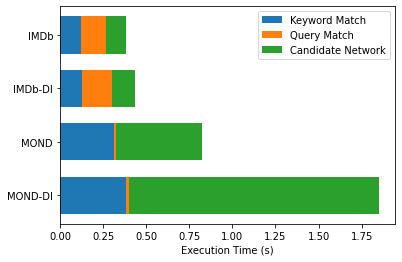

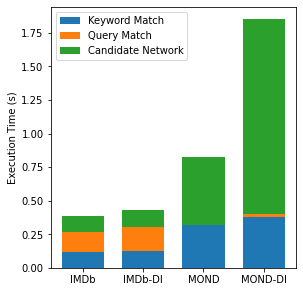

In [11]:
from statistics import fmean
def plot_performance_bar(evaluation,vertical=True):
    databases = ['imdb','mondial']

    querysets_hash = {
        'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
        'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
    } 

    labels_hash = {
        'coffman_imdb_renamed':'IMDb',
        'coffman_imdb_renamed_clear_intents':'IMDb-DI',
        'coffman_mondial':'MOND',
        'coffman_mondial_clear_intents':'MOND-DI',
    }
    
    experiments = {
        'km':'Keyword Match',
        'qm':'Query Match',
        'cn':'Candidate Network',
    }
    
    
    data = [[],[],[]]
    tick_labels = []
    for database in databases:
        for queryset in querysets_hash[database]:
            tick_labels.append(labels_hash[queryset])
            for i,experiment in enumerate(experiments):
                data[i].append(fmean(evaluation[database][queryset]['standard']['performance'][experiment]))
                
    N = len(labels_hash)
    sequence = np.arange(N)
    previous = np.zeros(N)
    
    width = 0.7
    
    if vertical:
        layout = 'vertical'
        figsize = [4.4, 4.8]
        fig, ax = plt.subplots(figsize=figsize)

        for i,(experiment,label) in enumerate(experiments.items()):        
            plt.bar(sequence, data[i], width, label=label,bottom=previous)
            previous+=data[i]
        plt.ylabel('Execution Time (s)')
        plt.xticks(sequence, tick_labels)
    else:
        layout = 'horizontal'
        fig, ax = plt.subplots()
        for i,(experiment,label) in enumerate(experiments.items()):
            plt.barh(sequence, data[i], width, label=label,left=previous)
            previous+=data[i]
        plt.xlabel('Execution Time (s)')
        plt.yticks(sequence, tick_labels)
        ax.invert_yaxis()

    plt.legend()
    
    
    filename = f'{config.plots_directory}performance-evaluation-{layout}.pdf'
    plt.savefig(filename)
    plt.show()

plot_performance_bar(evaluation,vertical=False)
plot_performance_bar(evaluation,vertical=True)

## Weighting Schemes Analysis

In [12]:
# from time import sleep

# original_plot_dir = '../../plots/'
# for i in range(4):
#     subfolder = f'weighting_scheme_{i}/'
#     evaluation = load_evaluations(databases,approaches)
#     config.plots_directory=f'{original_plot_dir}weighting_scheme_{i}_'
    
#     if i>0:
#         print('-'*100)
#         print('-'*100)
        
#     print(f'Weighting Scheme {i}\n')
#     print('Query Matches')
#     query_matches_precision_plot(evaluation)
        
#     print('Instance Pruning')
#     instance_pruning_plot(evaluation) 

# config.plots_directory=original_plot_dir

In [13]:
# metrics = ['mrr']+[f'p@{k+1}' for k in range(4)]
# group_labels = [name.upper() for name in metrics]

# weighting_schemes = list(range(4))

# approaches = {
#     'standard':'Std',
#     'pospruning':'Pos',
#     'prepruning':'Pre',
# }

# databases = ['imdb','mondial']

# querysets_hash = {
#     'imdb'   :['coffman_imdb_renamed','coffman_imdb_renamed_clear_intents'],
#     'mondial':['coffman_mondial','coffman_mondial_clear_intents'],
# } 

# labels = {
#     'coffman_mondial':'MOND',
#     'coffman_mondial_clear_intents':'MOND-DI',
#     'coffman_imdb_renamed':'IMDb',
#     'coffman_imdb_renamed_clear_intents':'IMDb-DI',
# }

# lines = []
# for database in databases: 
#     lines.append(database)
#     title_querysets = [labels[queryset] for queryset in querysets_hash[database]]    
#     title_line1= ', '.join(title_querysets)
#     lines.append(title_line1)
    
#     title_approaches = list(approaches.values())*len(querysets_hash[database])*len(metrics)
#     title_line2 = ', '.join(['scheme']+title_approaches)
#     lines.append(title_line2)
#     for weighting_scheme in weighting_schemes:
#         subfolder = f'weighting_scheme_{weighting_scheme}/'
#         evaluation = load_evaluations(databases,approaches,subfolder=subfolder)
        
#         values = [
#             '{:.2f}'.format(evaluation[database][queryset][approach]['candidate_networks'][metric])
#             for metric in metrics
#             for queryset in querysets_hash[database]
#             for approach in approaches
#         ]
#         cur_line = ', '.join([str(weighting_scheme)]+values)
#         lines.append(cur_line)
        
# for line in lines:
#     print(line)

In [15]:
from string import punctuation,ascii_uppercase,ascii_lowercase

In [18]:
punctuation.replace('_','')

'!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'

In [20]:
{1:2,3:4}-{1}

TypeError: unsupported operand type(s) for -: 'dict' and 'set'